In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [131]:
df = pd.read_csv('mid_cap_all_sectors_ret.csv')
df['date'] = pd.to_datetime(df['date'])

## **Only Log Return Feature**

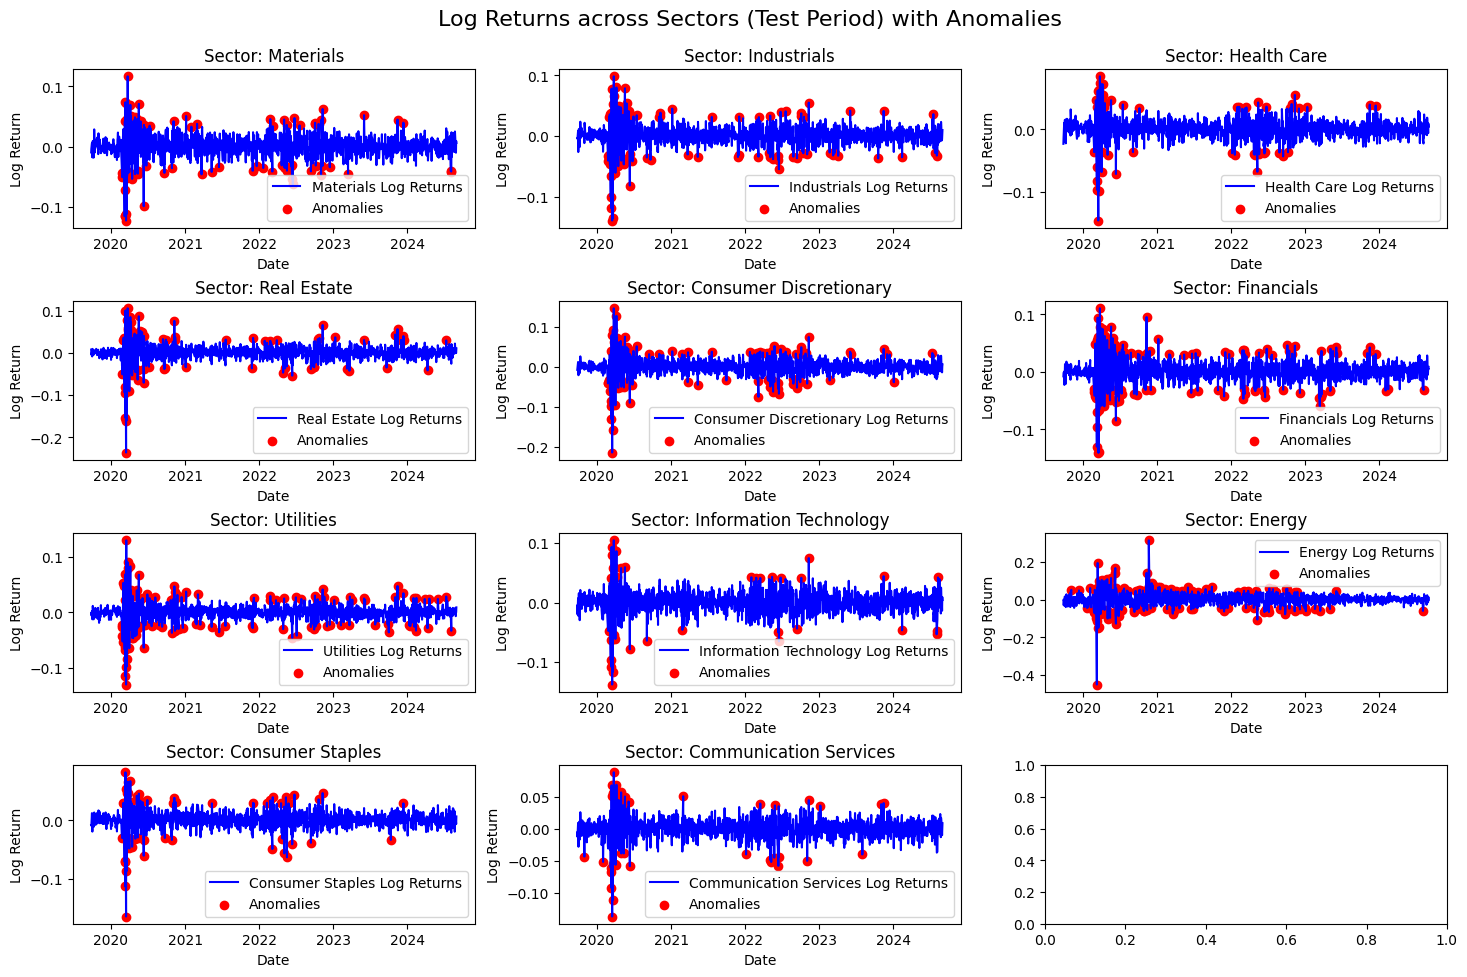

,silhouette_score,mse,anomaly_percentage
Materials,0.633350,0.027044,6.446414
Industrials,0.634953,0.027042,7.332796
Health Care,0.679724,0.023364,4.029009
Real Estate,0.689354,0.033522,6.043513
Consumer Discretionary,0.621188,0.024427,7.977438
Financials,0.613583,0.026790,9.427881
Utilities,0.634419,0.024755,9.427881
Information Technology,0.692284,0.022788,2.900886
Energy,0.574521,0.023244,11.522965
Consumer Staples,0.682315,0.030614,4.270749


In [132]:
sectors = df.columns[1:]

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (only the log returns for the sector)
    X_train = train_df[[sector]].values
    X_test = test_df[[sector]].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df

## **Log Return & Rolling Vol**

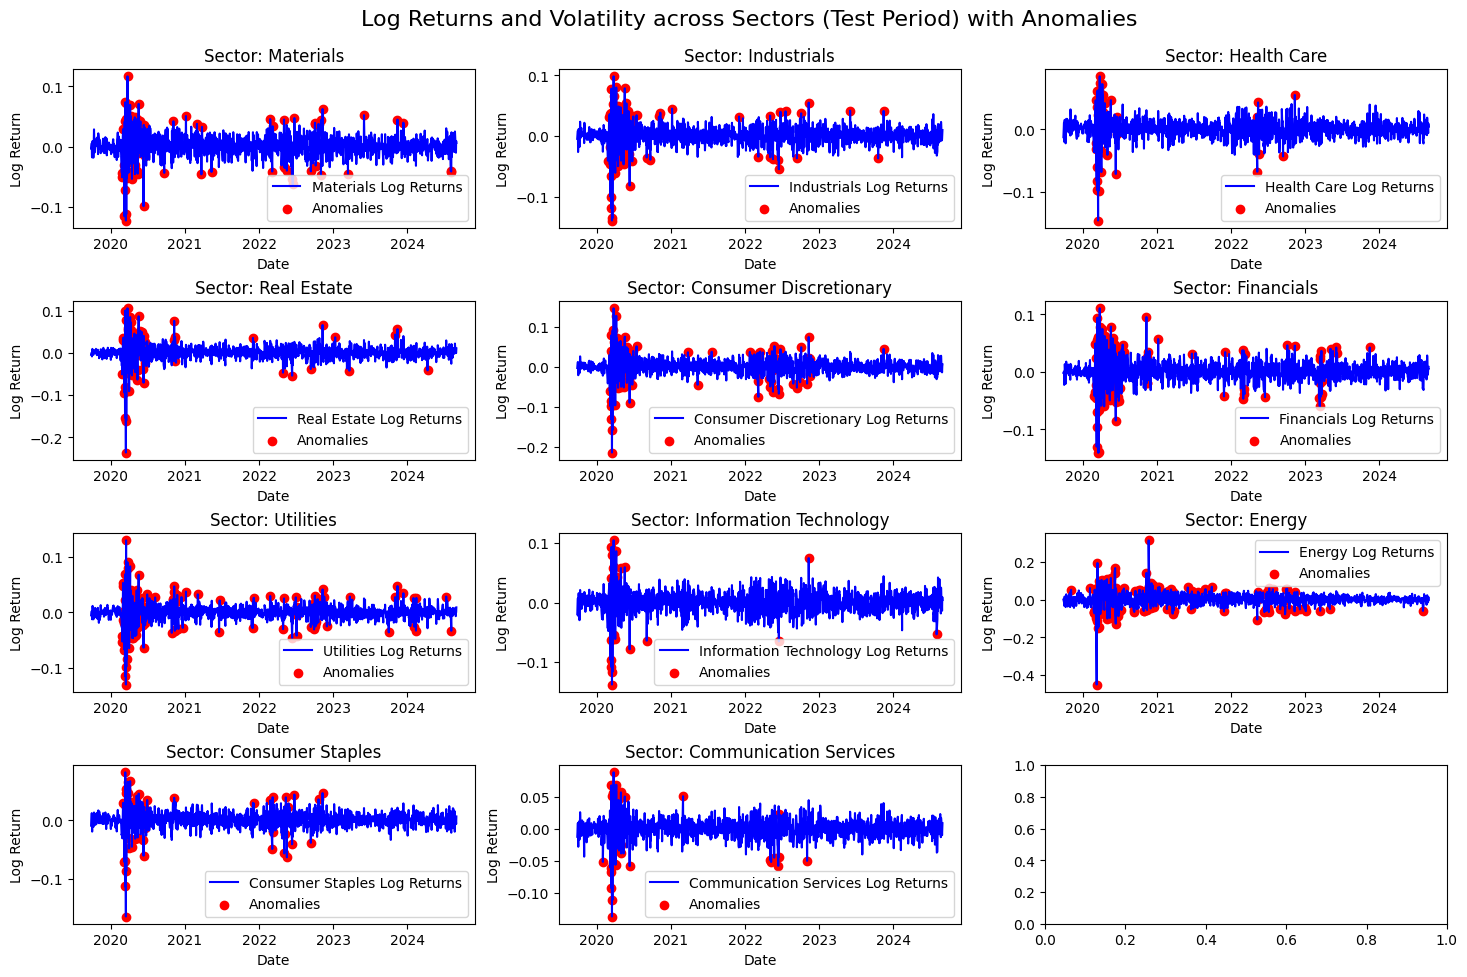

,silhouette_score,mse,anomaly_percentage
Materials,0.619371,0.024397,6.612903
Industrials,0.631485,0.025209,7.016129
Health Care,0.694686,0.025237,3.306452
Real Estate,0.717531,0.031645,5.000000
Consumer Discretionary,0.619575,0.025419,7.741935
Financials,0.620961,0.027915,8.467742
Utilities,0.624868,0.023449,9.596774
Information Technology,0.725573,0.027001,2.177419
Energy,0.559081,0.020216,11.935484
Consumer Staples,0.679176,0.024236,4.274194


In [133]:
# 5-day rolling volatility for each sector as an additional feature
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns and Volatility across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with both log returns and volatility as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns and 5-day rolling volatility)
    X_train = train_df[[sector, f'{sector}_vol_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df

## **Log Return & SMA & Rolling Vol**

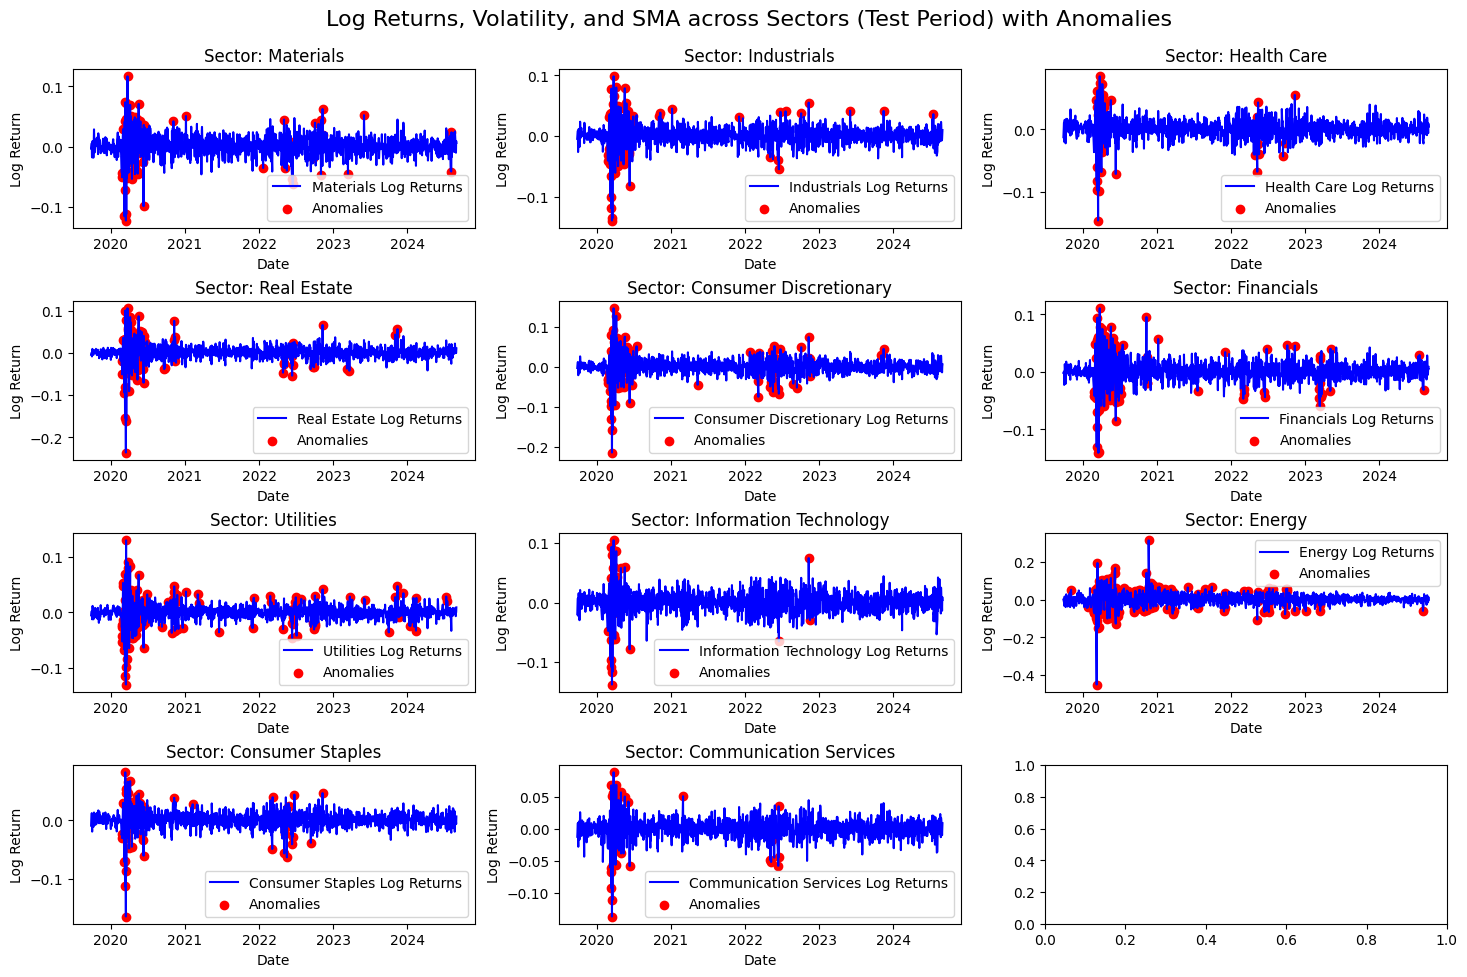

,silhouette_score,mse,anomaly_percentage
Materials,0.603130,0.025319,5.725806
Industrials,0.615562,0.024647,6.693548
Health Care,0.680138,0.026403,3.306452
Real Estate,0.668305,0.030400,6.290323
Consumer Discretionary,0.599461,0.024423,8.064516
Financials,0.606354,0.027655,8.145161
Utilities,0.598361,0.020094,9.596774
Information Technology,0.699175,0.029146,2.258065
Energy,0.518940,0.020889,13.145161
Consumer Staples,0.657630,0.025274,4.354839


In [134]:
# 5-day rolling volatility and 5-day SMA for each sector as additional features
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()
    df[f'{sector}_sma_5'] = df[sector].rolling(window=5).mean()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns, Volatility, and SMA across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with log returns, volatility, and SMA as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns, 5-day rolling volatility, and 5-day SMA)
    X_train = train_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df